# June 16, 2024: fit sbms on graphs

In [1]:
import csv
import os
import sys
import numpy as np
import pandas as pd
import scipy as sp 
import dill as pickle 
from os.path import join as pjoin
from itertools import product
from tqdm import tqdm
from copy import deepcopy
from pathlib import Path
import subprocess
from scipy import sparse, stats
from multiprocessing import Pool
import glob

# import arviz as az

from itertools import product, combinations

# networks
import graph_tool.all as gt

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

# import cmasher as cmr  # CITE ITS PAPER IN YOUR MANUSCRIPT

# ignore user warnings
import warnings
warnings.filterwarnings("ignore") #, category=UserWarning)

In [2]:
gt.__version__

'2.79 (commit f935ec6a, )'

In [3]:
class ARGS():
    pass

args = ARGS()

args.SEED = 100

gt.seed_rng(args.SEED)
np.random.seed(args.SEED)

In [4]:
args.type = 'spatial'
args.roi_size = 225
args.maintain_symmetry = True
args.brain_div = 'whl'
args.num_rois = 162

PARC_DESC = (
    f'type-{args.type}'
    f'_size-{args.roi_size}'
    f'_symm-{args.maintain_symmetry}'
    f'_braindiv-{args.brain_div}'
    f'_nrois-{args.num_rois}'
)

In [5]:
args.GRAPH_DEF = f'constructed'
args.GRAPH_METHOD = f'pearson-corr'
args.THRESHOLDING = f'positive'
args.EDGE_DEF = f'binary'
args.EDGE_DENSITY = 20
args.LAYER_DEF = f'individual'
args.DATA_UNIT = f'ses'

BASE_path = f'{os.environ["HOME"]}/mouse_dataset/roi_results_v2'
ROI_path = f'{BASE_path}/{PARC_DESC}'
TS_path = f'{ROI_path}/runwise_timeseries'
ROI_RESULTS_path = (
    f'{ROI_path}'
    f'/graph-{args.GRAPH_DEF}/method-{args.GRAPH_METHOD}'
    f'/threshold-{args.THRESHOLDING}/edge-{args.EDGE_DEF}/density-{args.EDGE_DENSITY}'
    f'/layer-{args.LAYER_DEF}/unit-{args.DATA_UNIT}'
)
GRAPH_path = f'{ROI_RESULTS_path}/graphs'
os.system(f'mkdir -p {GRAPH_path}')
SBM_path = f'{ROI_RESULTS_path}/model-fits'
os.system(f'mkdir -p {SBM_path}')

0

In [6]:
args.dc = True
args.sbm = 'o'
args.wait = 12 #6000
args.force_niter = 500 #10000
args.niter = 10
args.Bs = '1' #' '.join([str(i) for i in (np.round(np.linspace(1, args.num_rois, 5)).astype(int))])

In [7]:
args.num_draws = int((1/2) * args.force_niter)

In [8]:
def sbm_name(args):
    dc = f'dc' if args.dc else f'nd'
    dc = f'' if args.sbm in ['a'] else dc
    file = f'sbm-{dc}-{args.sbm}'
    return file

SBM = sbm_name(args)
SBM

'sbm-dc-o'

In [9]:
files = sorted(glob.glob(f'{GRAPH_path}/*', recursive=True))
file = files[0]

In [10]:
ss = '_'.join([s for s in file.split('/') if 'sub' in s][0].split('_')[:2])
ss

'sub-SLC01_ses-1'

In [11]:
g = gt.load_graph(file)
g

<Graph object, undirected, with 162 vertices and 2608 edges, 1 internal edge property, at 0x7f37e4e99c70>

In [12]:
with open(f'graph.pkl', 'wb') as f:
    pickle.dump(g, f)

In [13]:
args.Bs

'1'

In [14]:
def mcmc_eq(args, g, state):
    bs = [] # partitions
    Bs = np.zeros(g.num_vertices() + 1) # number of blocks
    Bes = [] # number of effective blocks
    dls = [] # description length history
    def collect_partitions(s):
        bs.append(s.b.a.copy())
        B = s.get_nonempty_B()
        Bs[B] += 1
        Bes.append(s.get_Be())
        dls.append(s.entropy())
        
    gt.mcmc_equilibrate(
        state, 
        wait=args.wait, 
        force_niter=args.force_niter,
        mcmc_args=dict(niter=args.niter), 
        callback=collect_partitions,
    )
    return state, bs, Bs, Bes, dls

In [15]:
# stateo = gt.minimize_blockmodel_dl(
#     g, 
#     state=gt.OverlapBlockState,
#     state_args=dict(deg_corr=True, B=1),
# )
# stateo

with open(f'graph.pkl', 'rb') as f:
    g = pickle.load(f)

stateo = gt.OverlapBlockState(g, **dict(deg_corr=True, B=41))
stateo

<OverlapBlockState object with 41 blocks, degree corrected, for graph <Graph object, undirected, with 162 vertices and 2608 edges, 1 internal edge property, at 0x7f37e4e98290>, at 0x7f37e4e6b3e0>

In [16]:
stateo, bs, Bs, Bes, dls = mcmc_eq(args, g, stateo)

: 

In [ ]:
Bes

[4.998836620709602,
 5.999014819144572,
 5.998935220720601,
 6.99617757021276,
 6.998197181094259,
 6.998518485974266,
 6.998518485974266,
 6.998518485974266,
 6.998518485974266,
 6.998518485974266,
 6.998518485974266,
 6.998518485974266,
 6.998518485974266,
 6.998518485974266,
 6.998518485974266,
 6.998518485974266,
 6.998518485974266,
 6.998518485974266,
 6.998518485974269,
 6.998518485974269,
 6.998518485974269,
 6.998518485974269,
 6.998518485974269,
 6.9984063258546465,
 6.9984063258546465,
 6.9984063258546465,
 6.9984063258546465,
 6.9984063258546465,
 6.9984063258546465,
 6.9984063258546465,
 6.9984063258546465,
 6.9984063258546465,
 6.9984063258546465,
 6.9984063258546465,
 6.9984063258546465,
 6.9984063258546465,
 6.9984063258546465,
 6.9984063258546465,
 6.9984063258546465,
 6.9984063258546465,
 6.9984063258546465,
 6.9984063258546465,
 6.9984063258546465,
 6.9984063258546465,
 6.9984063258546465,
 6.9984063258546465,
 6.9984063258546465,
 6.9984063258546465,
 6.9984063258546

In [ ]:
os.system((
    f'bash 02a-graph-individual-binary_desc-equilibrate.sh '
    f'{file} ' 
    f'{args.sbm} ' 
    f'{args.dc} ' 
    f'{args.wait} ' 
    f'{args.force_niter} ' 
    f'"{args.Bs}" '
    f'{args.SEED} '
))

In [ ]:
sbm_files = sorted(glob.glob(f'{SBM_path}/{ss}/{SBM}/*/desc-partitions.pkl'))
sbm_files

with open(sbm_files[0], 'rb') as f:
    var = pickle.load(f)

# var

In [ ]:
chains_df = []
for idx, sbm_file in tqdm(enumerate(sbm_files)):
    with open(sbm_file, 'rb') as f:
        [bs, Bs, Bes, dls] = pickle.load(f)
    
    Bes = Bes[0] if args.sbm in ['h'] else Bes
    
    df = pd.DataFrame({
        'chain': [idx],
        # 'state':[state],
        'Bs': [Bs],
        'Bes': [Bes],
        'dls': [dls],
        'bs':[bs],
        # 'modes': [modes],
        # 'evidence': [L],
    })
    chains_df.append(df)
    
chains_df = pd.concat(chains_df).reset_index(drop=True)

5it [00:00, 124.66it/s]


In [ ]:
chains_df

,chain,Bs,Bes,dls,bs
0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 998.0, 0.0, 0.0...","[4.99779121504749, 5.990173990820626, 5.993730...","[7054.462261910424, 7392.271824107299, 7262.43...","[[934, 1211, 1211, 1315, 1367, 1315, 934, 1315..."
1,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[114.93999591569747, 112.74177118883797, 111.1...","[11754.507906914381, 10908.613264985446, 10327...","[[70, 27, 49, 112, 39, 48, 63, 74, 27, 74, 49,..."
2,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[148.1378872340359, 143.66292110039706, 136.61...","[12389.64567148907, 11359.558517288378, 10882....","[[58, 116, 118, 139, 58, 140, 118, 86, 91, 75,..."
3,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[40.27507043033958, 39.70037011073194, 39.3947...","[9618.442377685584, 8647.96677945936, 7585.246...","[[1, 30, 28, 31, 40, 22, 21, 36, 7, 39, 21, 8,..."
4,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[79.8643108426197, 78.45585951518497, 78.36346...","[10976.306080375025, 9969.231858765002, 9567.7...","[[70, 57, 35, 51, 18, 51, 60, 27, 56, 47, 35, ..."


[Text(0.5, 1.0, 'trace plot'),
 Text(0, 0.5, '$B_e$'),
 Text(0.5, 0, 'MCMC sweep'),
 (0.0, 30.0)]

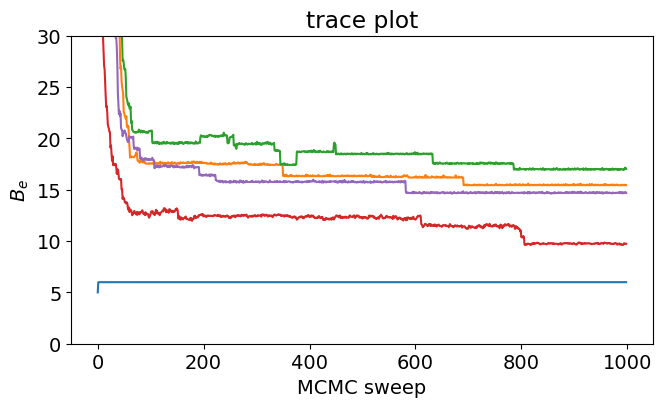

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(7.5, 4))
ax = axs
for idx, row in chains_df.iterrows():
    ax.plot(row['Bes'])
ax.set(title='trace plot', ylabel='$B_e$', xlabel='MCMC sweep', ylim=[0, 30])

In [ ]:
chs_df = chains_df.explode(['Bes', 'dls', 'bs']).reset_index(drop=True)
chs_df

,chain,state,Bs,Bes,dls,bs,modes,evidence
0,0,"<NestedBlockState object, with base <BlockStat...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",42.303587,4022.909103,"[[102, 11, 96, 65, 90, 90, 115, 48, 92, 56, 84...",[<graph_tool.inference.partition_modes.Partiti...,-3109.537787
1,0,"<NestedBlockState object, with base <BlockStat...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",37.345648,3621.442219,"[[14, 13, 13, 65, 90, 48, 53, 48, 92, 56, 44, ...",[<graph_tool.inference.partition_modes.Partiti...,-3109.537787
2,0,"<NestedBlockState object, with base <BlockStat...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",32.69884,3525.96344,"[[48, 11, 13, 65, 102, 102, 49, 48, 92, 49, 44...",[<graph_tool.inference.partition_modes.Partiti...,-3109.537787
3,0,"<NestedBlockState object, with base <BlockStat...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",29.314046,3430.655301,"[[48, 11, 13, 12, 102, 44, 49, 33, 92, 49, 44,...",[<graph_tool.inference.partition_modes.Partiti...,-3109.537787
4,0,"<NestedBlockState object, with base <BlockStat...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",26.841869,3376.644339,"[[48, 13, 13, 12, 102, 44, 49, 48, 92, 49, 44,...",[<graph_tool.inference.partition_modes.Partiti...,-3109.537787
...,...,...,...,...,...,...,...,...
1240,4,"<NestedBlockState object, with base <BlockStat...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",15.729258,3212.350098,"[[44, 28, 28, 49, 51, 44, 77, 44, 77, 77, 44, ...",[<graph_tool.inference.partition_modes.Partiti...,-3097.290943
1241,4,"<NestedBlockState object, with base <BlockStat...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",15.90386,3217.610412,"[[44, 28, 28, 49, 51, 44, 31, 44, 31, 31, 44, ...",[<graph_tool.inference.partition_modes.Partiti...,-3097.290943
1242,4,"<NestedBlockState object, with base <BlockStat...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",15.843961,3218.558065,"[[44, 28, 28, 49, 51, 51, 28, 44, 31, 31, 44, ...",[<graph_tool.inference.partition_modes.Partiti...,-3097.290943
1243,4,"<NestedBlockState object, with base <BlockStat...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",15.625387,3215.682237,"[[44, 28, 28, 49, 51, 44, 31, 44, 31, 31, 51, ...",[<graph_tool.inference.partition_modes.Partiti...,-3097.290943


In [ ]:
def KSD(args, chains_df):
    chain_idxs = chains_df.index.to_list()
    print(chain_idxs)
    
    ksd_dfs = []
    for idx1, idx2 in tqdm(combinations(chain_idxs, 2)):
        Bes_ch1 = chains_df.iloc[idx1]['Bes']
        Bes_ch2 = chains_df.iloc[idx2]['Bes']
        Ds = []
        for t in range(10, args.force_niter, 50):
            res = stats.ks_2samp(Bes_ch1[:t], Bes_ch2[:t])
            Ds.append(res.statistic)
        df = pd.DataFrame({
            'ch1': [idx1] * len(Ds),
            'ch2': [idx2] * len(Ds),
            't': np.arange(10, args.force_niter, 50),
            'D': Ds,
        })
        ksd_dfs.append(df)
    ksd_dfs = pd.concat(ksd_dfs).reset_index(drop=True)
    return ksd_dfs
    
ksd_dfs = KSD(args, chains_df)

[0, 1, 2, 3, 4]


10it [00:00, 10.57it/s]


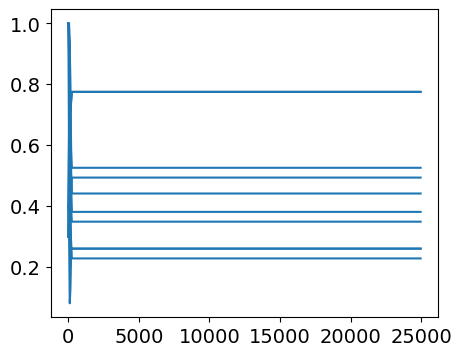

In [ ]:
def plot_KSD(args, chains_df, ksd_dfs, ax):
    chain_idxs = chains_df.index.to_list()
    for idx1, idx2 in combinations(chain_idxs, 2):
        t_D = ksd_dfs[
            (ksd_dfs['ch1'] == idx1) &
            (ksd_dfs['ch2'] == idx2)
        ][['t', 'D']].to_numpy()
        ax.plot(t_D[:, 0], t_D[:, 1], c='tab:blue')
    return None

fig, axs = plt.subplots(1, 1, figsize=(5, 4))
ax = axs
plot_KSD(args, chains_df, ksd_dfs, ax)

[Text(0.5, 0, 'MCMC sweep'), Text(0, 0.5, '$\\hat{R}$')]

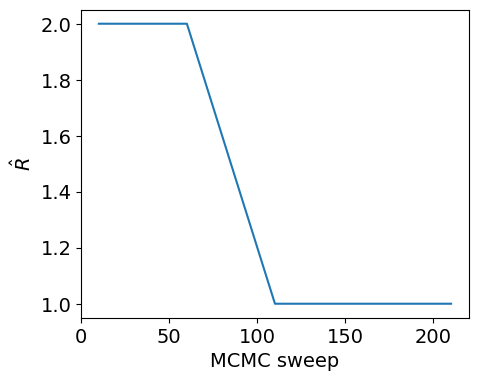

In [ ]:
def Rhat(args, chains_df):
    chain_idxs = chains_df.index.to_list()
    chains = np.stack(chains_df['Bes'].to_list(), axis=0)
    
    ts = np.arange(10, chains.shape[-1], 50)
    rhats = np.zeros_like(ts)
    for i, t in enumerate(ts):
        rhats[i] = az.rhat(chains[:, :t])
    return ts, rhats

fig, axs = plt.subplots(1, 1, figsize=(5, 4))
ax = axs
ts, rhats = Rhat(args, chains_df)
ax.plot(ts, rhats)
ax.set(xlabel=f'MCMC sweep', ylabel='$\hat{R}$')

In [ ]:
cols = ['Bes', 'dls', 'bs']
for col in cols:
    chains_df[col] = chains_df[col].apply(lambda x: x[-args.num_draws:])

chs_df = chains_df.explode(cols).reset_index(drop=True)
chs_df

,chain,state,Bs,Bes,dls,bs,modes,evidence
0,0,"<NestedBlockState object, with base <BlockStat...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",42.303587,4022.909103,"[[102, 11, 96, 65, 90, 90, 115, 48, 92, 56, 84...",[<graph_tool.inference.partition_modes.Partiti...,-3109.537787
1,0,"<NestedBlockState object, with base <BlockStat...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",37.345648,3621.442219,"[[14, 13, 13, 65, 90, 48, 53, 48, 92, 56, 44, ...",[<graph_tool.inference.partition_modes.Partiti...,-3109.537787
2,0,"<NestedBlockState object, with base <BlockStat...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",32.69884,3525.96344,"[[48, 11, 13, 65, 102, 102, 49, 48, 92, 49, 44...",[<graph_tool.inference.partition_modes.Partiti...,-3109.537787
3,0,"<NestedBlockState object, with base <BlockStat...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",29.314046,3430.655301,"[[48, 11, 13, 12, 102, 44, 49, 33, 92, 49, 44,...",[<graph_tool.inference.partition_modes.Partiti...,-3109.537787
4,0,"<NestedBlockState object, with base <BlockStat...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",26.841869,3376.644339,"[[48, 13, 13, 12, 102, 44, 49, 48, 92, 49, 44,...",[<graph_tool.inference.partition_modes.Partiti...,-3109.537787
...,...,...,...,...,...,...,...,...
1240,4,"<NestedBlockState object, with base <BlockStat...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",15.729258,3212.350098,"[[44, 28, 28, 49, 51, 44, 77, 44, 77, 77, 44, ...",[<graph_tool.inference.partition_modes.Partiti...,-3097.290943
1241,4,"<NestedBlockState object, with base <BlockStat...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",15.90386,3217.610412,"[[44, 28, 28, 49, 51, 44, 31, 44, 31, 31, 44, ...",[<graph_tool.inference.partition_modes.Partiti...,-3097.290943
1242,4,"<NestedBlockState object, with base <BlockStat...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",15.843961,3218.558065,"[[44, 28, 28, 49, 51, 51, 28, 44, 31, 31, 44, ...",[<graph_tool.inference.partition_modes.Partiti...,-3097.290943
1243,4,"<NestedBlockState object, with base <BlockStat...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",15.625387,3215.682237,"[[44, 28, 28, 49, 51, 44, 31, 44, 31, 31, 51, ...",[<graph_tool.inference.partition_modes.Partiti...,-3097.290943


In [ ]:
df = []
for idx_chain in chs_df['chain'].unique():
    df.append(chs_df[chs_df['chain'] == idx_chain].iloc[-args.num_draws:])
chs_df = pd.concat(df).reset_index(drop=True)
chs_df

,chain,state,Bs,Bes,dls,bs,modes,evidence
0,0,"<NestedBlockState object, with base <BlockStat...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",42.303587,4022.909103,"[[102, 11, 96, 65, 90, 90, 115, 48, 92, 56, 84...",[<graph_tool.inference.partition_modes.Partiti...,-3109.537787
1,0,"<NestedBlockState object, with base <BlockStat...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",37.345648,3621.442219,"[[14, 13, 13, 65, 90, 48, 53, 48, 92, 56, 44, ...",[<graph_tool.inference.partition_modes.Partiti...,-3109.537787
2,0,"<NestedBlockState object, with base <BlockStat...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",32.69884,3525.96344,"[[48, 11, 13, 65, 102, 102, 49, 48, 92, 49, 44...",[<graph_tool.inference.partition_modes.Partiti...,-3109.537787
3,0,"<NestedBlockState object, with base <BlockStat...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",29.314046,3430.655301,"[[48, 11, 13, 12, 102, 44, 49, 33, 92, 49, 44,...",[<graph_tool.inference.partition_modes.Partiti...,-3109.537787
4,0,"<NestedBlockState object, with base <BlockStat...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",26.841869,3376.644339,"[[48, 13, 13, 12, 102, 44, 49, 48, 92, 49, 44,...",[<graph_tool.inference.partition_modes.Partiti...,-3109.537787
...,...,...,...,...,...,...,...,...
1240,4,"<NestedBlockState object, with base <BlockStat...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",15.729258,3212.350098,"[[44, 28, 28, 49, 51, 44, 77, 44, 77, 77, 44, ...",[<graph_tool.inference.partition_modes.Partiti...,-3097.290943
1241,4,"<NestedBlockState object, with base <BlockStat...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",15.90386,3217.610412,"[[44, 28, 28, 49, 51, 44, 31, 44, 31, 31, 44, ...",[<graph_tool.inference.partition_modes.Partiti...,-3097.290943
1242,4,"<NestedBlockState object, with base <BlockStat...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",15.843961,3218.558065,"[[44, 28, 28, 49, 51, 51, 28, 44, 31, 31, 44, ...",[<graph_tool.inference.partition_modes.Partiti...,-3097.290943
1243,4,"<NestedBlockState object, with base <BlockStat...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",15.625387,3215.682237,"[[44, 28, 28, 49, 51, 44, 31, 44, 31, 31, 51, ...",[<graph_tool.inference.partition_modes.Partiti...,-3097.290943


(10.0, 20.0)

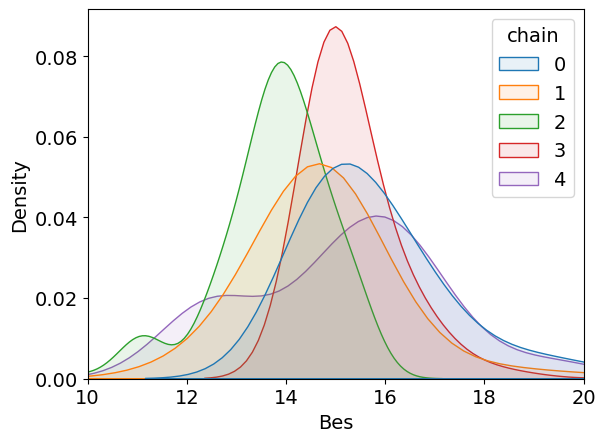

In [ ]:
sns.kdeplot(data=chs_df, x='Bes', hue='chain', fill=True, palette='tab10', alpha=0.1)
plt.xlim([10, 20])

---

In [ ]:
# # modes within each chain
# for idx, row in chains_df.iterrows():
#     pmode = gt.ModeClusterState(row['bs'], nested=True)
#     gt.mcmc_equilibrate(pmode, wait=1, mcmc_args=dict(niter=1, beta=np.inf))
#     modes = pmode.get_modes()
#     break

In [ ]:
# M = len(pmode.bs)
# omegas = []
# sigmas = []
# for mode in pmode.get_modes():
#     omega = mode.get_M() / M
#     omegas.append(omega)
#     sigma = mode.posterior_cdev()
#     sigmas.append(sigma)

In [ ]:
import graph_tool.all as gt
import pickle
import numpy as np

with open('bs.npy', 'rb') as f:
    [state, bs] = pickle.load(f)
    
pmode = gt.ModeClusterState(bs, nested=True)
gt.mcmc_equilibrate(pmode, wait=1, mcmc_args=dict(niter=1, beta=np.inf))

with open('pmode.npy', 'wb') as f:
    pickle.dump([state, bs, pmode], f)
    
with open('pmode.npy', 'rb') as f:
    [state, bs, pmode] = pickle.load(f)

In [ ]:
g = state.g
g.save(f'graph.gt.gz')

In [ ]:
from scipy.special import gammaln
import graph_tool.all as gt
import numpy as np
import pickle

def nested_mcmc_eq(args, g, state):
    bs = []
    Bs = [np.zeros(g.num_vertices() + 1) for s in state.get_levels()]
    Bes = [[] for s in state.get_levels()]
    dls = []
    def collect_partitions(s):
        bs.append(s.get_bs())
        for l, sl in enumerate(s.get_levels()):
            B = sl.get_nonempty_B()
            Bs[l][B] += 1
            Be = sl.get_Be()
            Bes[l].append(Be)
        dls.append(s.entropy())
        
    gt.mcmc_equilibrate(
        state, 
        wait=args.wait, 
        force_niter=args.force_niter, 
        mcmc_args=dict(niter=args.niter),
        callback=collect_partitions,
    )
    return state, bs, Bs, Bes, dls

def nested_total_evidence(pmode, bs, dls):
    H = pmode.posterior_entropy()
    logB = np.mean([sum(gammaln(len(np.unique(bl))+1) for bl in b) for b in bs])
    L = -np.mean(dls) + logB + H
    return L

In [ ]:
print(gt.__version__)
class ARGS(): pass
args = ARGS()

args.SEED = 100
gt.seed_rng(args.SEED)
np.random.seed(args.SEED)

g = gt.load_graph('graph.gt.gz')
state = gt.NestedBlockState(g, deg_corr=False)
args.wait = 100
args.force_niter = 1000
args.niter = 10


2.77 (commit 1697da74, )


In [ ]:
state, bs, Bs, Bes, dls = nested_mcmc_eq(args, g, state)

In [ ]:
pmode = gt.ModeClusterState(bs, nested=True)
gt.mcmc_equilibrate(pmode, wait=1, mcmc_args=dict(niter=1, beta=np.inf))

(62345.97490528798, 3009, 0)

In [ ]:
L = nested_total_evidence(pmode, bs, dls)

In [ ]:
with open(f'output_{gt.__version__}.pkl', 'wb') as f:
    pickle.dump([g, state, bs, Bs, Bes, dls, pmode, L], f)

In [ ]:
with open(f'output_{gt.__version__}.pkl', 'rb') as f:
    [g, state, bs, Bs, Bes, dls, pmode, L] = pickle.load(f)